# Regression example: *Synthetic* 2 dataset


   $$y  = x_1^2$$




## Librairies 

In [1]:
import os, sys, time
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [5]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import EarlyStopping,LRScheduler,Checkpoint, TrainEndCheckpoint, EpochScoring
from skorch.dataset import Dataset
from skorch.helper import predefined_split

In [6]:
from SRAModels import TabSRALinearRegressor,InputShapeSetterTabSRA,LinearRegressor

In [7]:
from interpret.glassbox import ExplainableBoostingRegressor


In [8]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
set_visualize_provider(InlineProvider())

## Data

In [9]:
np.random.seed(42)
x1 = np.random.normal(0,1,3*10000)
x2 = np.random.normal(0,1,3*10000)
x3 = np.random.normal(0,1,3*10000)
x4 = np.random.normal(0,1,3*10000)
x5 = np.random.normal(0,1,3*10000)
X = np.concatenate((x1.reshape(-1,1), x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1)  ),axis=1)

In [10]:
odd = x1**2
y_c = 1/(1+np.exp(-odd))
y = np.where(y_c>0.5, 1,0)
X_train_,X_test_,Y_train_,Y_test_ = train_test_split(X,odd,stratify =y , random_state=42)
n_features, n_classes = 5,1
len(Y_train_),len(Y_test_)

(22500, 7500)

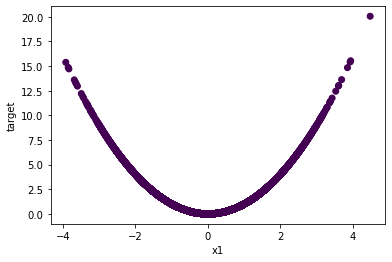

In [11]:
plt.scatter(x1, odd, c = y) #color[y]
plt.xlabel('x1')
plt.ylabel('target')
plt.show()

In [12]:
feature_names = ['x1','x2','x3','x4','x5']
X_train_ = pd.DataFrame(X_train_,columns=feature_names)
X_train_.head()

,x1,x2,x3,x4,x5
0,-1.134391,-0.948467,-0.364929,0.783069,0.584904
1,1.218258,-1.218910,-1.856787,-0.227586,0.499904
2,-0.530836,0.487124,0.840414,-0.837790,-0.942463
3,-1.262963,1.821977,0.637152,-0.866720,-0.347966
4,-0.197529,0.100225,1.408767,-1.410167,-0.126068


In [13]:
X_test_ = pd.DataFrame(X_test_,columns=feature_names)
X_test_.head()

,x1,x2,x3,x4,x5
0,0.033568,0.255569,0.915380,0.826291,0.032416
1,1.404306,0.279439,1.148543,0.372974,1.269521
2,-1.650489,-0.922853,-0.190185,0.480621,0.395107
3,-0.580741,0.807455,-0.807780,-0.804718,-0.263151
4,0.929896,0.478715,-2.090424,1.334225,0.940811


In [14]:
valid_dataset = Dataset(X_test_.values.astype(np.float32),Y_test_.reshape(-1,1).astype(np.float32))

## Model: LR (Linear Regression)

In [15]:
other_params_linear = {"module__bias":True,
                "optimizer__lr":0.5*1e-2,
                "optimizer__weight_decay":0.0,
                "random_state":42,
                "max_epochs":150,
                "batch_size":256,
                "device":'cuda'
               }
scoring = EpochScoring(scoring='r2',lower_is_better=False)
setter = InputShapeSetterTabSRA(regression=True)
early_stop = EarlyStopping(monitor=scoring.scoring, patience=20,load_best=True,lower_is_better=False, threshold=0.00001,threshold_mode='abs')
lr_scheduler = LRScheduler(policy=ReduceLROnPlateau, patience=10, min_lr=2e-5,factor=0.2, verbose=1,monitor='valid_loss', mode='min')
call_b = [scoring, setter, early_stop, lr_scheduler]

In [16]:
%%time
LR = LinearRegressor(**other_params_linear,train_split = predefined_split(valid_dataset),callbacks = call_b)#,
_ = LR.fit(X_train_.values.astype(np.float32),Y_train_.reshape(-1,1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__dim_input, module__dim_output.
Re-initializing criterion.
Re-initializing optimizer.
  epoch       r2    train_loss    valid_loss     dur
-------  -------  ------------  ------------  ------
      1  -0.0668        2.4014        2.0256  0.7227
      2  -0.0086        2.0862        1.9151  0.2050
      3  -0.0016        2.0354        1.9018  0.2315
      4  -0.0007        2.0302        1.9001  0.2246
      5  -0.0004        2.0295        1.8995  0.2235
      6  -0.0007        2.0303        1.9002  0.2107
      7  -0.0011        2.0303        1.9009  0.2481
      8  -0.0011        2.0299        1.9008  0.2146
      9  -0.0027        2.0303        1.9039  0.2444
     10  -0.0028        2.0297        1.9041  0.2157
     11  -0.0009        2.0303        1.9005  0.2360
     12  -0.0013        2.0299        1.9012  0.2807
     13  -0.0024        2.0307        1.9034  0.2275
     14  -0.0011        2.0298        1.900

In [17]:
Coef  = pd.DataFrame(LR.get_weights()[0])
Coef = Coef
Coef.columns=feature_names
Coef

,x1,x2,x3,x4,x5
0,-0.000025,-0.000953,-0.007318,-0.014759,-0.014158


In [18]:
pred_tab_lr = LR.predict(X_test_.values.astype(np.float32))
rmse = np.sqrt(mean_squared_error(Y_test_, pred_tab_lr))
r2 = r2_score(Y_test_, pred_tab_lr) 
print(f"--RMSE perf = {rmse} -- r2 perf = {r2}")

--RMSE perf = 1.378235192967729 -- r2 perf = -0.00039174581029000066


## Model: TabSRALinear 

In [19]:
#valid_loss
other_params = {"module__encoder_bias":True,
                "module__classifier_bias":True,
                "module__n_hidden_encoder":1,
                "module__n_head":2,
                "module__dim_head":4,
                "optimizer__lr":0.01,
                "max_epochs":150,
                "batch_size":256,                
                "optimizer__weight_decay":1e-4,
                "random_state":42,
               }
scoring = EpochScoring(scoring='r2',lower_is_better=False)
setter = InputShapeSetterTabSRA(regression=True)
early_stop = EarlyStopping(monitor=scoring.scoring, patience=20,load_best=True,lower_is_better=False, threshold=0.00001,threshold_mode='abs')
lr_scheduler = LRScheduler(policy=ReduceLROnPlateau, patience=15, min_lr=2e-5,factor=0.2, verbose=1, mode='max',monitor=scoring.scoring)
call_b = [scoring, setter, early_stop, lr_scheduler]

In [20]:
%%time
TabSRA = TabSRALinearRegressor(**other_params,callbacks=call_b,train_split = predefined_split(valid_dataset))
_ = TabSRA.fit(X_train_.values.astype(np.float32),Y_train_.reshape(-1,1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__dim_input, module__dim_output.
Re-initializing criterion.
Re-initializing optimizer.
  epoch      r2    train_loss    valid_loss     dur
-------  ------  ------------  ------------  ------
      1  0.6738        1.7792        0.6194  0.5271
      2  0.8968        0.4326        0.1959  0.4872
      3  0.9592        0.1606        0.0774  0.4873
      4  0.9778        0.0786        0.0421  0.4834
      5  0.9862        0.0479        0.0263  0.4871
      6  0.9902        0.0327        0.0186  0.4851
      7  0.9928        0.0242        0.0137  0.4907
      8  0.9941        0.0188        0.0113  0.4832
      9  0.9951        0.0152        0.0093  0.4872
     10  0.9960        0.0124        0.0077  0.5193
     11  0.9965        0.0106        0.0067  0.4922
     12  0.9967        0.0092        0.0062  0.5496
     13  0.9974        0.0076        0.0050  0.4928
     14  0.9975        0.0068        0.0047  0.4849
     1

In [21]:
Coef  = pd.DataFrame(TabSRA.get_weights()[0])
#Coef = Coef.T
Coef.columns=feature_names
Coef

,x1,x2,x3,x4,x5
0,4.362339,0.513503,0.245996,0.461156,0.310329


In [22]:
Coef  = pd.DataFrame(TabSRA.get_weights()[1])
#Coef = Coef.T
Coef.columns=feature_names
Coef

,x1,x2,x3,x4,x5
0,-4.303967,-0.506356,-0.245187,-0.466954,-0.307837


In [23]:
pred_tabsra = TabSRA.predict(X_test_.values.astype(np.float32))

rmse_tabsra = np.sqrt(mean_squared_error(Y_test_, pred_tabsra))
r2_tabsra = r2_score(Y_test_, pred_tabsra) 
print(f"--RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")

--RMSE perf = 0.015340014900939518 -- r2 perf = 0.9998760704159692


## Model: EBM_S & EBM

In [24]:
%%time
EBM_S = ExplainableBoostingRegressor(interactions=0,max_rounds=2500,early_stopping_rounds=50,validation_size=0)#max_bins=256#,inner_bags=100,outer_bags=100 # 10
EBM_S.fit(X_train_, Y_train_)

/home/kodjo/anaconda3/lib/python3.9/site-packages/interpret/glassbox/_ebm/_ebm.py:426: UserWarning: If validation_size is 0, the outer_bags have no purpose. Set outer_bags=1 to remove this warning.
  warn(


CPU times: user 270 ms, sys: 384 ms, total: 654 ms
Wall time: 3.2 s


ExplainableBoostingRegressor(interactions=0, max_rounds=2500, validation_size=0)

In [25]:
pred_EBM_S = EBM_S.predict(X_test_)

rmse_ebm_s = np.sqrt(mean_squared_error(Y_test_, pred_EBM_S))
r2_ebm_s = r2_score(Y_test_, pred_EBM_S) 
print(f"--RMSE perf = {rmse_ebm_s} -- r2 perf = {r2_ebm_s}")

--RMSE perf = 0.14475000522149167 -- r2 perf = 0.9889652981030436


In [26]:
#show(EBM_S.explain_global())

In [27]:
%%time
EBM = ExplainableBoostingRegressor(interactions=4,max_rounds=2500,early_stopping_rounds=50,validation_size=0)#max_bins=256#,inner_bags=100,outer_bags=100 # 10
EBM.fit(X_train_, Y_train_)

/home/kodjo/anaconda3/lib/python3.9/site-packages/interpret/glassbox/_ebm/_ebm.py:426: UserWarning: If validation_size is 0, the outer_bags have no purpose. Set outer_bags=1 to remove this warning.
  warn(


CPU times: user 256 ms, sys: 7.96 ms, total: 264 ms
Wall time: 4.09 s


ExplainableBoostingRegressor(interactions=4, max_rounds=2500, validation_size=0)

In [28]:
pred_EBM = EBM.predict(X_test_)

rmse_ebm = np.sqrt(mean_squared_error(Y_test_, pred_EBM))
r2_ebm = r2_score(Y_test_, pred_EBM) 
print(f"--RMSE perf = {rmse_ebm} -- r2 perf = {r2_ebm}")

--RMSE perf = 0.1478511993140261 -- r2 perf = 0.9884874075046428


In [29]:
#show(EBM.explain_global(name=feature_names))

## Model: XGBoost 

In [30]:
from xgboost import XGBRegressor


/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [31]:
def buildXGBoost(config_opt,static_params):
    config_opt.update(static_params)
    model_xgb = XGBRegressor(**config_opt)
    return model_xgb

In [32]:
### These parameters are optimized using 30 trials with optuna (bayesian optimization)
config_opt_xgb = {
              'eta': 0.03425616464106714,
              'max_depth': 5,
              'colsample_bytree': 1.0,
              'subsample': 1.0,
              'n_estimators': 1100,
              'min_child_weight':56

              }
static_params_xgb = {
                 'random_state':45,
                 'n_jobs': -1,
}


In [33]:
%%time
model_xgb = buildXGBoost(config_opt=config_opt_xgb,static_params=static_params_xgb)
eval_set = [(X_test_, Y_test_)]
model_xgb.fit(X_train_, Y_train_, eval_metric=['rmse'], eval_set=eval_set, verbose=0)

/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 1min 25s, sys: 1min 4s, total: 2min 30s
Wall time: 9.65 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             eta=0.03425616464106714, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.034256164,
             max_delta_step=0, max_depth=5, min_child_weight=56, missing=nan,
             monotone_constraints='()', n_estimators=1100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=45,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
# Inference for xgboost 
pred_xgboost = model_xgb.predict(X_test_)
best_rmse_xgb = np.sqrt(mean_squared_error(Y_test_, pred_xgboost) )
best_r2_xgb = r2_score(Y_test_, pred_xgboost) 
print(f"--RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")

--RMSE perf = 0.10741151662949029 -- r2 perf = 0.993923897009329


## Interpretability: using feature attribution on the test data

- For Linear Regression, the effect is given by $\beta\odot x$ where $\beta$ is the regression coefficients.
- For TabSRALinear, the feature attribution vector is $\beta\odot a\odot x$ where $\beta$ is the linear regression coefficients, $a$ the SRA attention weights $\in [0,1]$ and $x$ the input vector.
- For XGBoost, we will use TreeSHAP https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html to get the feature attribution.

In [35]:
%%time
attributions_linear = pd.DataFrame(LR.get_feature_attribution(X_test_.values))
attributions_linear.columns = feature_names
attributions_linear['pred_proba'] = pred_tab_lr
attributions_linear['label'] = Y_test_

CPU times: user 80.4 ms, sys: 116 ms, total: 196 ms
Wall time: 14.9 ms


In [36]:
%%time
attributions_tabsra = pd.DataFrame(TabSRA.get_feature_attribution(X_test_.values))
attributions_tabsra.columns = feature_names
attributions_tabsra['pred_proba'] = pred_tabsra
attributions_tabsra['label'] = Y_test_

CPU times: user 69.7 ms, sys: 140 ms, total: 210 ms
Wall time: 14.5 ms


In [37]:
def get_feature_attribution_EBM(model, X_test):
    tmp  = model.explain_local(X_test)
    df_EBM = []
    for i in range(len(X_test)):
        df_EBM.append(tmp.data(i)['scores'])
    df_EBM = pd.DataFrame(df_EBM)
    df_EBM.columns = tmp.data(0)['names']
    return df_EBM

In [38]:
%%time
attributions_EBM_S = get_feature_attribution_EBM(EBM_S, X_test_)


CPU times: user 996 ms, sys: 1.39 s, total: 2.39 s
Wall time: 190 ms


In [39]:
%%time
attributions_EBM = get_feature_attribution_EBM(EBM, X_test_)


CPU times: user 125 ms, sys: 7.61 ms, total: 133 ms
Wall time: 131 ms


In [40]:
%%time
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred'] = pred_xgboost
attributions_xgb['label'] = Y_test_

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 17 s, sys: 500 ms, total: 17.5 s
Wall time: 1.58 s


LR --RMSE perf = 1.378235192967729 -- r2 perf = -0.00039174581029000066


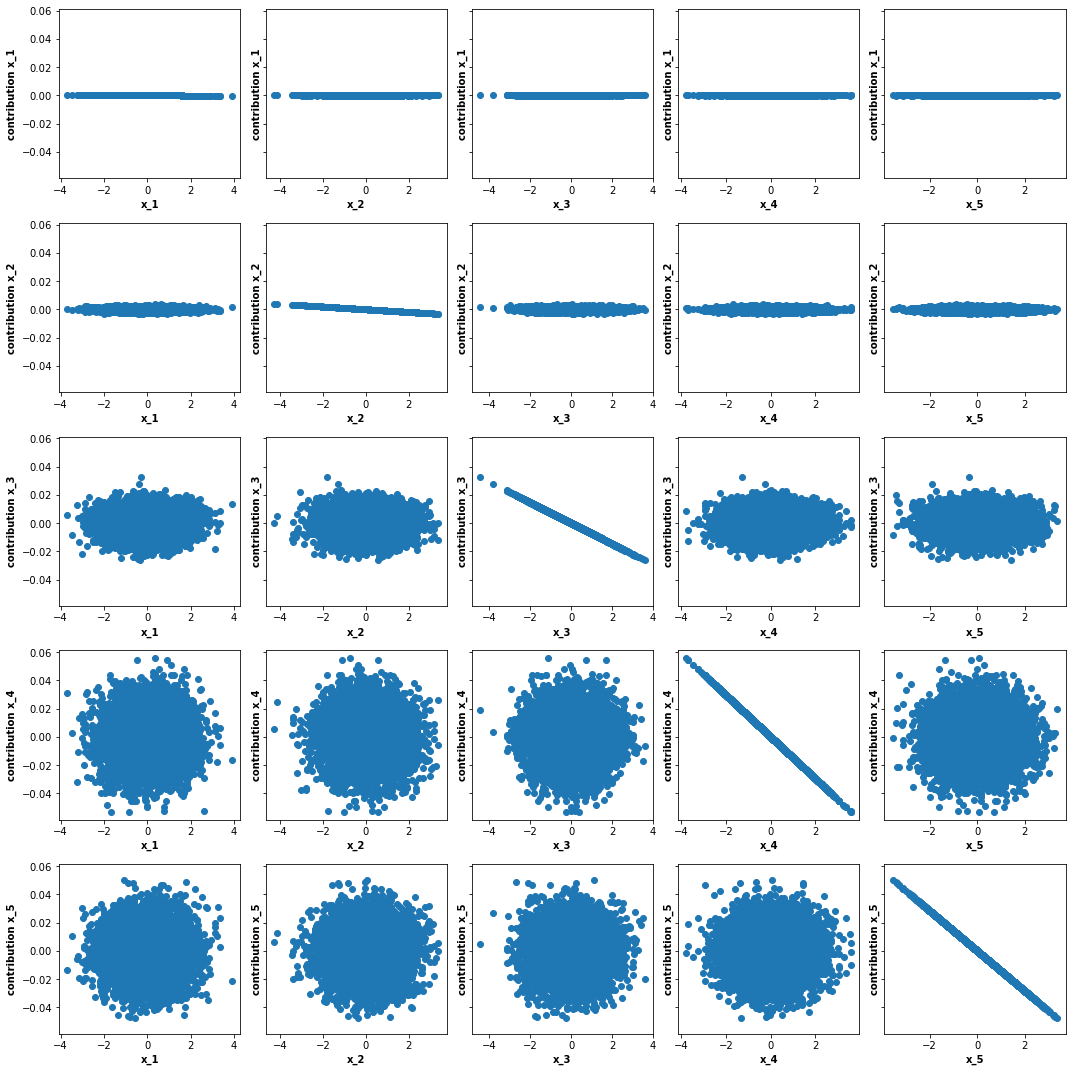

In [41]:
print(f"LR --RMSE perf = {rmse} -- r2 perf = {r2}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(X_test_[f"x{j+1}"], attributions_linear[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

TabSRALinear --RMSE perf = 0.015340014900939518 -- r2 perf = 0.9998760704159692


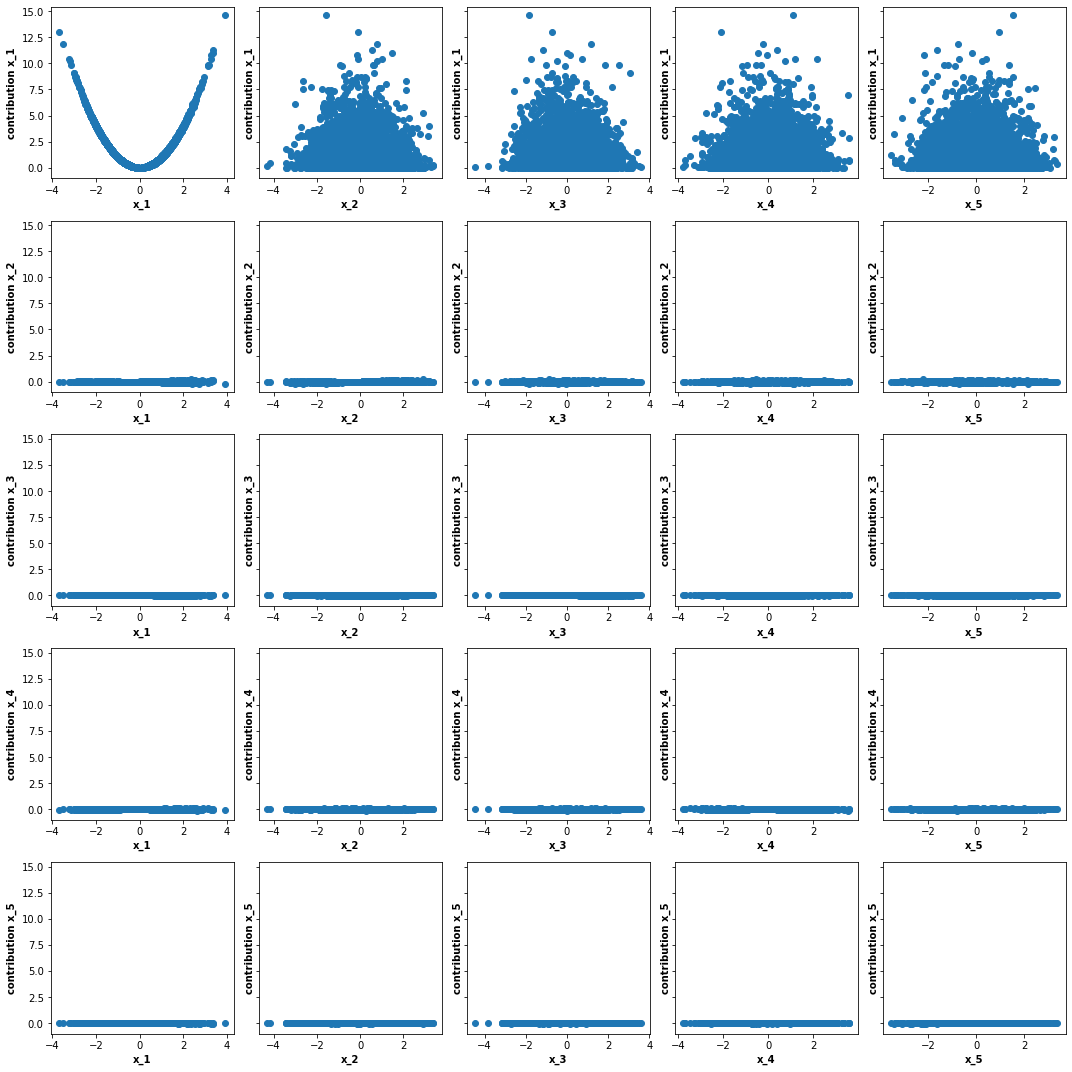

In [42]:
print(f"TabSRALinear --RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(X_test_[f"x{j+1}"], attributions_tabsra[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

EBM_S --RMSE perf = 0.14475000522149167 -- r2 perf = 0.9889652981030436


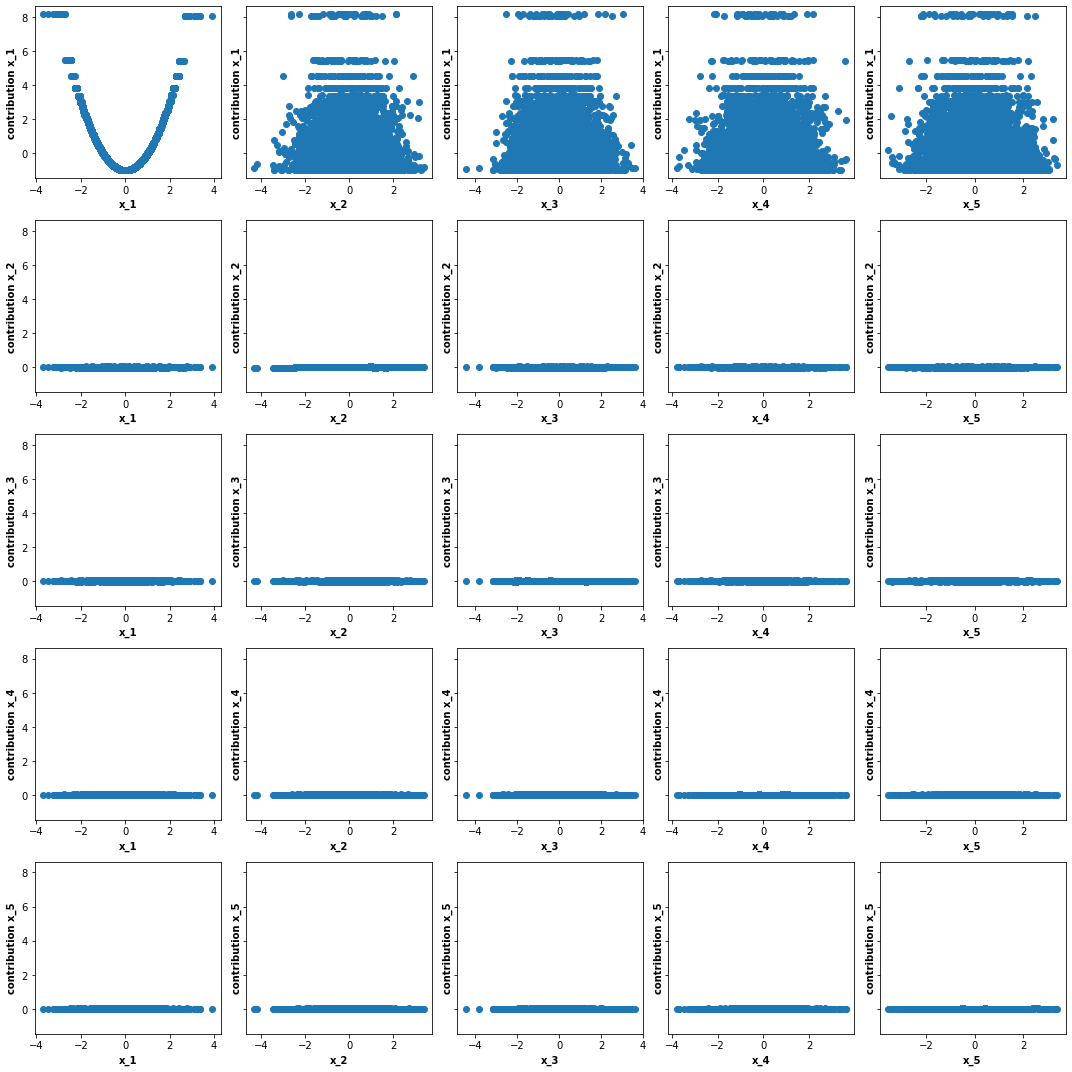

In [43]:
print(f"EBM_S --RMSE perf = {rmse_ebm_s} -- r2 perf = {r2_ebm_s}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(X_test_[f"x{j+1}"], attributions_EBM_S[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

XGBoost --RMSE perf = 0.10741151662949029 -- r2 perf = 0.993923897009329


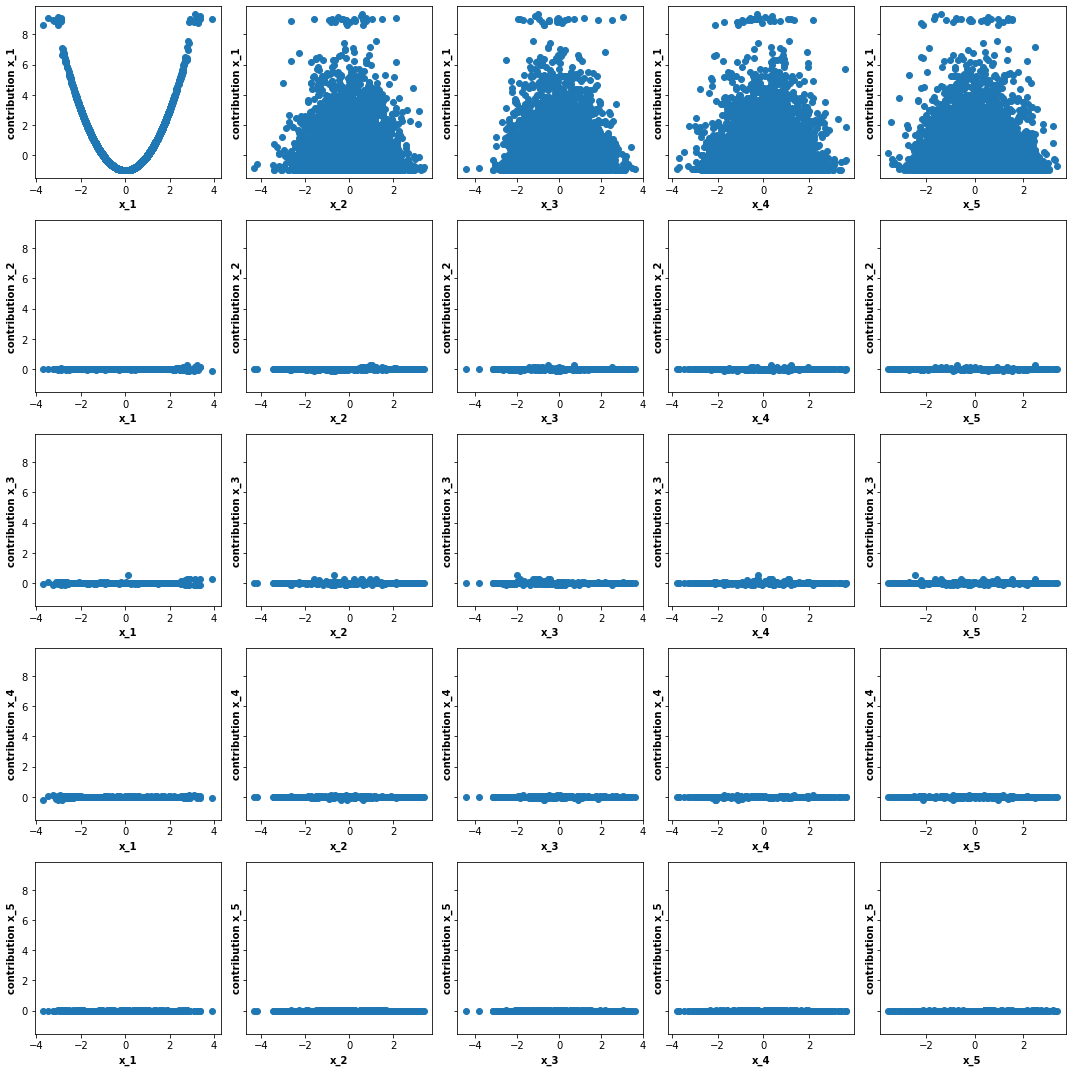

In [44]:
print(f"XGBoost --RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(X_test_[f"x{j+1}"], attributions_xgb[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

## Identification of important features

Only $x_1$ should
have nonzero importance

In [72]:
condition = X_test_.x1.abs()>0.05
condition.sum()

7193

In [67]:
precision_lr = np.argsort(attributions_linear[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0]).intersection(set(x[4:5]))),axis=1)
precision_lr.mean()

0.0

In [68]:
precision_tabsra = np.argsort(attributions_tabsra[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0]).intersection(set(x[4:5]))),axis=1)
precision_tabsra.mean()

0.9962463506186571

In [69]:
precision_ebm_s = np.argsort(attributions_EBM_S[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0]).intersection(set(x[4:5]))),axis=1)
precision_ebm_s.mean()

0.9940219658000834

In [70]:
precision_ebm = np.argsort(attributions_EBM[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0]).intersection(set(x[4:5]))),axis=1)
precision_ebm.mean()

0.9940219658000834

In [71]:
precision_xgb= np.argsort(attributions_xgb[condition][['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0]).intersection(set(x[4:5]))),axis=1)
precision_xgb.mean()

0.999026831641874